<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [3]:
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.util import *
from os.path import abspath, join
from pymodulon.io import *
from pymodulon.compare import *

In [4]:
# venn diagram
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

In [5]:
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster import hierarchy
import matplotlib.patches as mpatches

# Ica Data Object

In [6]:
# Enter the location of your data here
data_dir = '/home/tahani/Documents/elongatus/data/1_iModulon/'

In [7]:
ica_data = IcaData(M = join(data_dir,'M_0.8.csv'),
                   A = join(data_dir,'A_0.8.csv'),
                   X = join(data_dir,'3_log_tpm_normalized_ICA.csv'),
                   gene_table = join(data_dir,'gene_info_operon.csv'),
                   sample_table = join(data_dir,'3_metadata_qc_ICA.csv'),
                   imodulon_table = join(data_dir,'imodulon_table_0.8.csv'),
                   trn = join(data_dir,'TRN.csv'),
                   threshold_method = 'kmeans')

In [8]:
# iMname = dict(zip(ica_data.imodulon_table.index, ica_data.imodulon_table['name']))
# for i in range(len(ica_data.imodulon_table.index)):
#     ica_data.rename_imodulons({i: iMname[i]})
    
# ica_data.imodulon_names[:5]

['SphR', 'IdiB', 'RpaB', 'SG_1', 'CmpR']

# Prime Data Object

In [29]:
X_prime = pd.read_csv(join(data_dir,'X_prime.csv'), index_col = 0)

In [30]:
A_prime = infer_activities(ica_data, X_prime)

/home/tahani/pymodulon/src/pymodulon/util.py:324: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  shared_genes = ica_data.M.index & data.index


In [31]:
ica_data_prime = IcaData(M = join(data_dir,'M_0.8.csv'),
                   A = A_prime,
                   X = X_prime,
                   gene_table = join(data_dir,'gene_info_operon.csv'),
                   sample_table = join(data_dir,'sample_table_prime.csv'),
                   imodulon_table = join(data_dir,'imodulon_table_0.8.csv'),
                   trn = join(data_dir,'TRN.csv'),
                   threshold_method = 'kmeans')

In [8]:
iMname = dict(zip(ica_data_prime.imodulon_table.index, ica_data_prime.imodulon_table['name']))
for i in range(len(ica_data_prime.imodulon_table.index)):
    ica_data_prime.rename_imodulons({i: iMname[i]})

NameError: name 'ica_data_prime' is not defined

In [ ]:
ica_data_prime.imodulon_names

# Figure 4

## With A Data

In [9]:
plot_iModulons = pd.read_csv(join(data_dir,'plot3.csv'), index_col = 0)
cl = plot_iModulons['color']

In [10]:
#get activities for imodulons 
data = ica_data.A.reindex(index = list(plot_iModulons.index))

In [11]:
#take the activities from projects of interest 
samples_in_rpaA = ica_data.sample_table[ica_data.sample_table.project == 'rpaA'].index
df_final0 = data[samples_in_rpaA]

In [12]:
#take the activities from projects of interest 
condition = ica_data.sample_table[ica_data.sample_table.project == 'rpaA'].condition
df_final0 = df_final0.rename(columns=dict(zip(df_final0.columns,condition)))

In [13]:
colors = plot_iModulons.color
colors.index = df_final0.index
correlations = df_final0.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

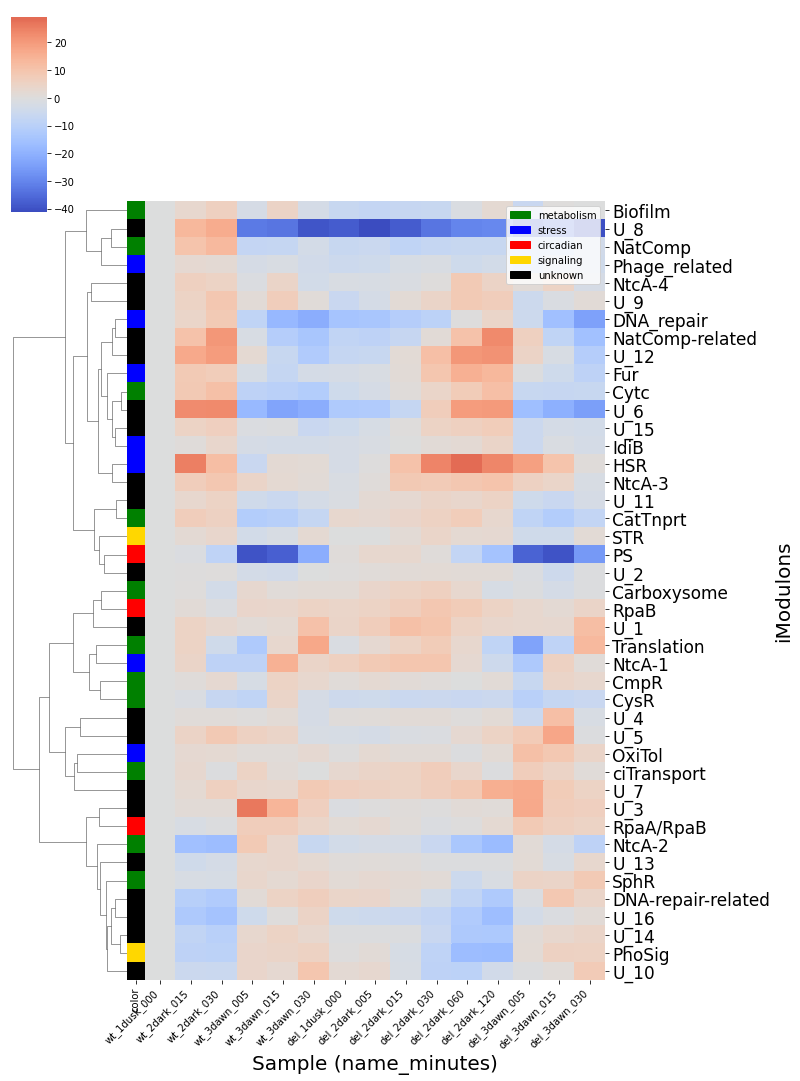

In [14]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10

f = sns.clustermap(df_final0, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
# f.set_xticks(range(len(df))) # <--- set the ticks first
f.ax_heatmap.set_xticklabels(list(ica_data.sample_table[ica_data.sample_table.project == 'rpaA'].condition),fontsize = 10,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'signaling','unknown']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)
None

In [15]:
#take the activities from projects of interest 
data = ica_data.sample_table[ica_data.sample_table.project == 'ppGpp']
ppGpp_wt = ica_data.sample_table[ica_data.sample_table.project == 'ppGpp'].condition.str.startswith("0wt_", na = False)
ppGpp_rel = ica_data.sample_table[ica_data.sample_table.project == 'ppGpp'].condition.str.startswith("1rel_", na = False)
ppGpp_samples = (data[ppGpp_wt].index).append(data[ppGpp_rel].index)
ppGpp_conditions = list((data[ppGpp_wt].condition).append(data[ppGpp_rel].condition))

In [16]:
SRX_condition = dict(zip(ppGpp_samples,ppGpp_conditions))

In [17]:
data = ica_data.A.reindex(index = list(plot_iModulons.index))
df = data[ppGpp_samples]
df = (df.rename(columns=dict(zip(ppGpp_samples,ppGpp_conditions)))).T
final_df = df.groupby(by=df.index).mean()
final_df = final_df.T
final_df

,0wt_dark_005,0wt_dark_015,0wt_dark_030,0wt_dark_060,0wt_dark_120,0wt_dark_240,0wt_dark_480,0wt_dark_720,0wt_dawn_000,0wt_dusk_000,1rel_dark_015,1rel_dark_030,1rel_dawn_000,1rel_dusk_000
SphR,3.349167,1.450973,0.028001,1.103660,2.391249,3.059486,-0.461539,-1.252542,-8.049117e-16,3.224418,-5.221868,-4.107864,-2.349700,-4.663141
IdiB,2.649459,2.076015,1.876444,1.568002,1.668888,1.178179,-0.555690,0.421458,-9.020562e-16,-0.485283,-3.289240,-3.542531,-3.836296,-3.852823
RpaB,-0.357444,-0.476824,-1.187963,-2.524703,-3.456859,-4.224986,-3.934641,-4.379831,5.516421e-16,0.755102,3.592233,2.044006,3.377090,2.700889
CmpR,6.314302,3.362705,-0.707720,-5.622286,-6.231795,-6.934554,-10.822253,-9.314137,-1.415534e-15,2.771935,-0.430343,-4.021067,-1.519153,-1.204581
PhoSig,-1.678423,-7.988673,-10.678335,-9.415556,-7.038251,-7.618973,-10.130100,-10.045906,-3.198830e-15,0.687220,-2.563953,-5.754243,1.375771,0.819841
Phage_related,2.343815,2.959218,2.786848,4.085977,2.994340,3.912596,3.042948,2.667419,9.436896e-16,1.254183,4.349738,3.612040,-7.389162,-1.196765
CysR,-6.107601,-9.008372,-11.251899,-12.181632,-11.799950,-11.943379,-14.324589,-14.403814,-4.905798e-15,-2.037470,-14.328172,-14.746982,-7.693459,-9.045626
CatTnprt,2.748675,4.393741,5.897733,7.032574,7.331394,4.941317,2.250257,0.659439,1.450229e-15,1.311722,5.652077,6.002871,-3.037970,3.353650
Translation,-0.092108,-1.480555,-7.481652,-11.818465,-11.394404,-9.946125,-5.681131,-7.505775,-6.106227e-16,-3.168919,5.709413,2.546146,1.406239,2.347409
Biofilm,1.393408,3.600999,5.526843,7.124969,7.003997,5.545149,4.419651,5.934310,1.401657e-15,1.639632,2.323442,2.733007,0.563336,0.734681


In [18]:
correlations = final_df.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

In [19]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10
# colors = plot_iModulons.color
# colors.index = plot_iModulons.index

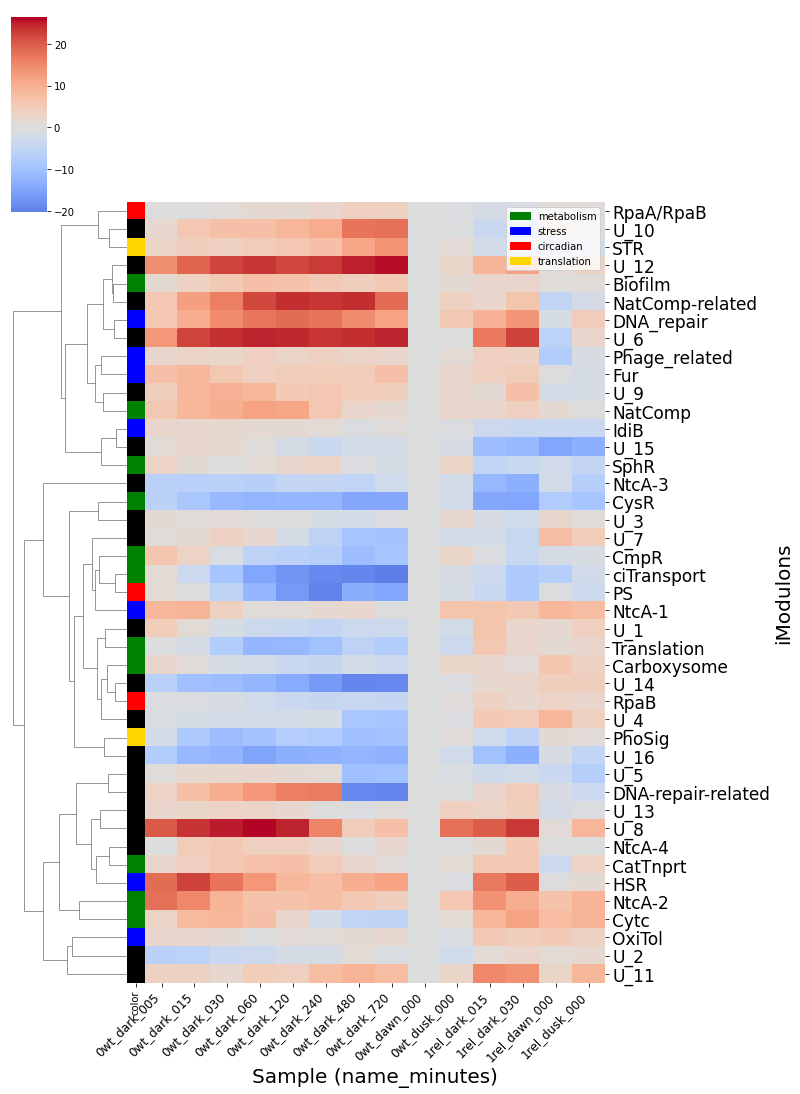

In [20]:
f = sns.clustermap(final_df, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
f.ax_heatmap.set_xticklabels(final_df.columns,fontsize = 12,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)

In [21]:
#take the activities from projects of interest 
data = ica_data.sample_table[ica_data.sample_table.project == 'light']
samples = ica_data.sample_table[ica_data.sample_table.project == 'light'].index
condition_LL = ica_data.sample_table[ica_data.sample_table.project == 'light'].condition.str.startswith("LL_", na = False)
condition_CD = ica_data.sample_table[ica_data.sample_table.project == 'light'].condition.str.startswith("CD_", na = False)

light_samples = (data[condition_LL].index).append(data[condition_CD].index)
light_conditions = list((data[condition_LL].condition).append(data[condition_CD].condition))

In [22]:
SRX_condition = dict(zip(light_samples,light_conditions))
SRX_condition

{'SRX3211304': 'LL_dawn_0.5h',
 'SRX3211305': 'LL_dawn_0.5h',
 'SRX3211306': 'LL_dawn_02h',
 'SRX3211307': 'LL_dawn_02h',
 'SRX3211308': 'LL_dawn_04h',
 'SRX3211309': 'LL_dawn_04h',
 'SRX3211310': 'LL_dawn_06h',
 'SRX3211311': 'LL_dawn_06h',
 'SRX3211312': 'LL_dawn_08h',
 'SRX3211313': 'LL_dawn_08h',
 'SRX3211314': 'LL_dawn_09h',
 'SRX3211315': 'LL_dawn_09h',
 'SRX3211316': 'LL_dawn_10h',
 'SRX3211317': 'LL_dawn_10h',
 'SRX3211318': 'LL_dawn_12h',
 'SRX3211319': 'LL_dawn_12h',
 'SRX3211320': 'CD_dawn_0.5h',
 'SRX3211321': 'CD_dawn_0.5h',
 'SRX3211322': 'CD_dawn_02h',
 'SRX3211323': 'CD_dawn_02h',
 'SRX3211324': 'CD_dawn_04h',
 'SRX3211325': 'CD_dawn_04h',
 'SRX3211326': 'CD_dawn_06h',
 'SRX3211327': 'CD_dawn_06h',
 'SRX3211328': 'CD_dawn_08h',
 'SRX3211329': 'CD_dawn_08h',
 'SRX3211330': 'CD_dawn_09h',
 'SRX3211331': 'CD_dawn_09h',
 'SRX3211332': 'CD_dawn_10h',
 'SRX3211333': 'CD_dawn_10h',
 'SRX3211334': 'CD_dawn_12h',
 'SRX3211335': 'CD_dawn_12h'}

In [23]:
data = ica_data.A.reindex(index = list(plot_iModulons.index))
df = data[light_samples]
df = (df.rename(columns=SRX_condition)).T
final_df2 = df.groupby(by=df.index).mean()
final_df2 = final_df2.T
final_df2

,CD_dawn_0.5h,CD_dawn_02h,CD_dawn_04h,CD_dawn_06h,CD_dawn_08h,CD_dawn_09h,CD_dawn_10h,CD_dawn_12h,LL_dawn_0.5h,LL_dawn_02h,LL_dawn_04h,LL_dawn_06h,LL_dawn_08h,LL_dawn_09h,LL_dawn_10h,LL_dawn_12h
SphR,9.992007e-16,-4.367771,-4.276249,-5.257807,-5.780951,-5.457464,-5.243847,-5.059899,1.321522,-4.169804,-3.536361,-5.010095,-4.491426,-3.707638,-3.684285,-4.057041
IdiB,3.108624e-15,-10.059126,-12.627607,-11.925897,-12.381127,-11.639658,-12.393875,-5.852066,-2.514102,-10.340487,-11.508327,-9.839930,-10.086583,-8.990403,-8.301146,-9.044983
RpaB,-5.551115e-16,3.804279,4.889447,7.871260,8.412143,7.540303,6.643376,2.487606,0.932624,1.352618,2.858189,4.231495,4.396347,5.190582,5.031666,5.394405
CmpR,2.275957e-15,-4.163864,-3.920443,-3.926540,-3.535736,-3.776101,-4.998796,-5.036260,-1.000552,-4.136053,-1.791765,-2.302975,-3.992289,-4.173076,-3.786361,-4.442398
PhoSig,-3.441691e-15,-0.057213,3.074923,4.065969,2.525114,2.468068,2.525571,-1.893054,5.448480,-3.687145,2.079502,4.233588,4.763666,4.380648,4.923004,6.484463
Phage_related,4.440892e-16,-1.560679,3.458060,1.658536,1.161690,0.277859,-0.240594,2.235563,-1.594642,-2.156043,-0.941645,-0.881030,-1.290061,-2.192254,-1.560642,-0.921476
CysR,-3.913536e-15,1.596427,-0.024729,0.376767,-1.800233,-1.998762,-2.068721,-3.746628,-0.918110,-1.099153,-0.485286,0.532722,1.724304,-0.992539,-1.306057,-1.395937
CatTnprt,-2.109424e-15,0.510367,-2.019179,1.530408,-0.107946,3.565258,4.078780,4.275769,-2.111231,-1.019506,1.494238,1.322968,1.462813,0.612817,0.701176,-0.302689
Translation,-8.881784e-16,15.445879,9.825304,8.648821,0.929126,-1.504818,-0.493245,-6.805674,10.930568,7.087724,-2.191477,-4.473360,-2.074489,2.097957,3.771241,4.184158
Biofilm,1.054712e-15,-7.932117,-8.314930,-5.512188,-0.756908,1.385600,0.682691,1.389904,-2.667664,-6.107070,-3.080178,1.263778,2.349082,-0.190884,0.044022,-3.508205


In [24]:
correlations = final_df2.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

In [25]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10
# colors = plot_iModulons.color
# colors.index = plot_iModulons.index

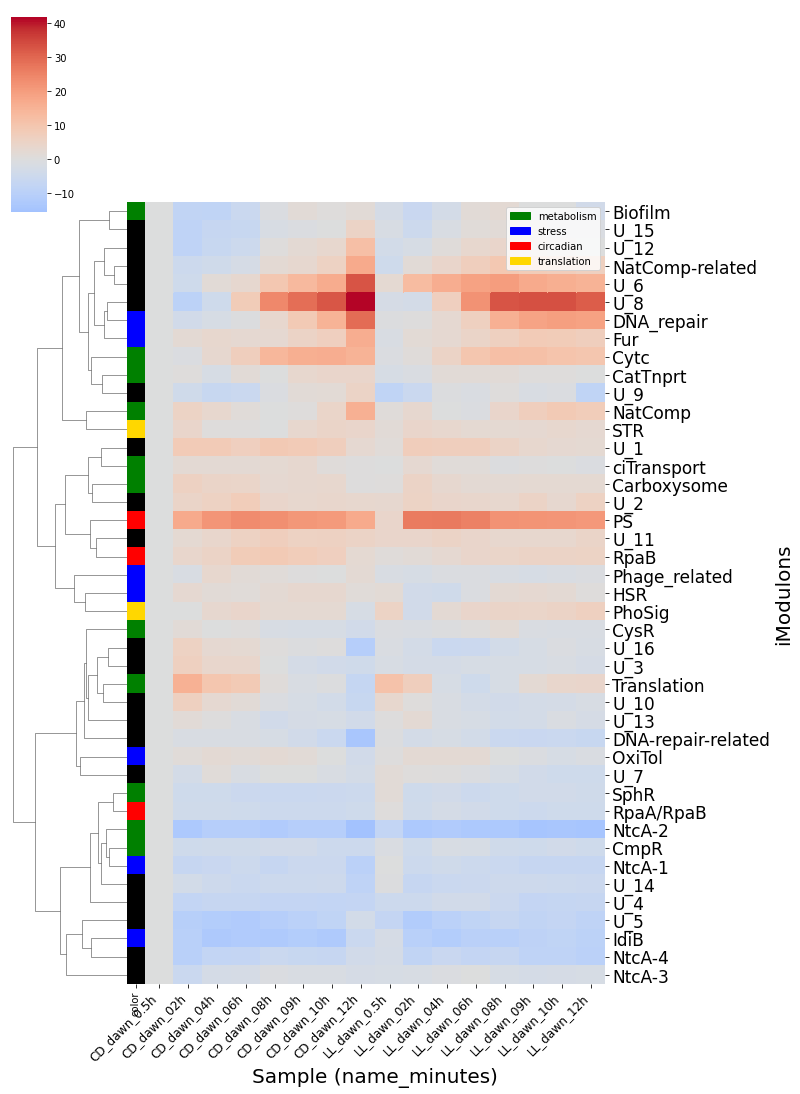

In [26]:
f = sns.clustermap(final_df2, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
f.ax_heatmap.set_xticklabels(final_df2.columns,fontsize = 12,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)

### Final figure

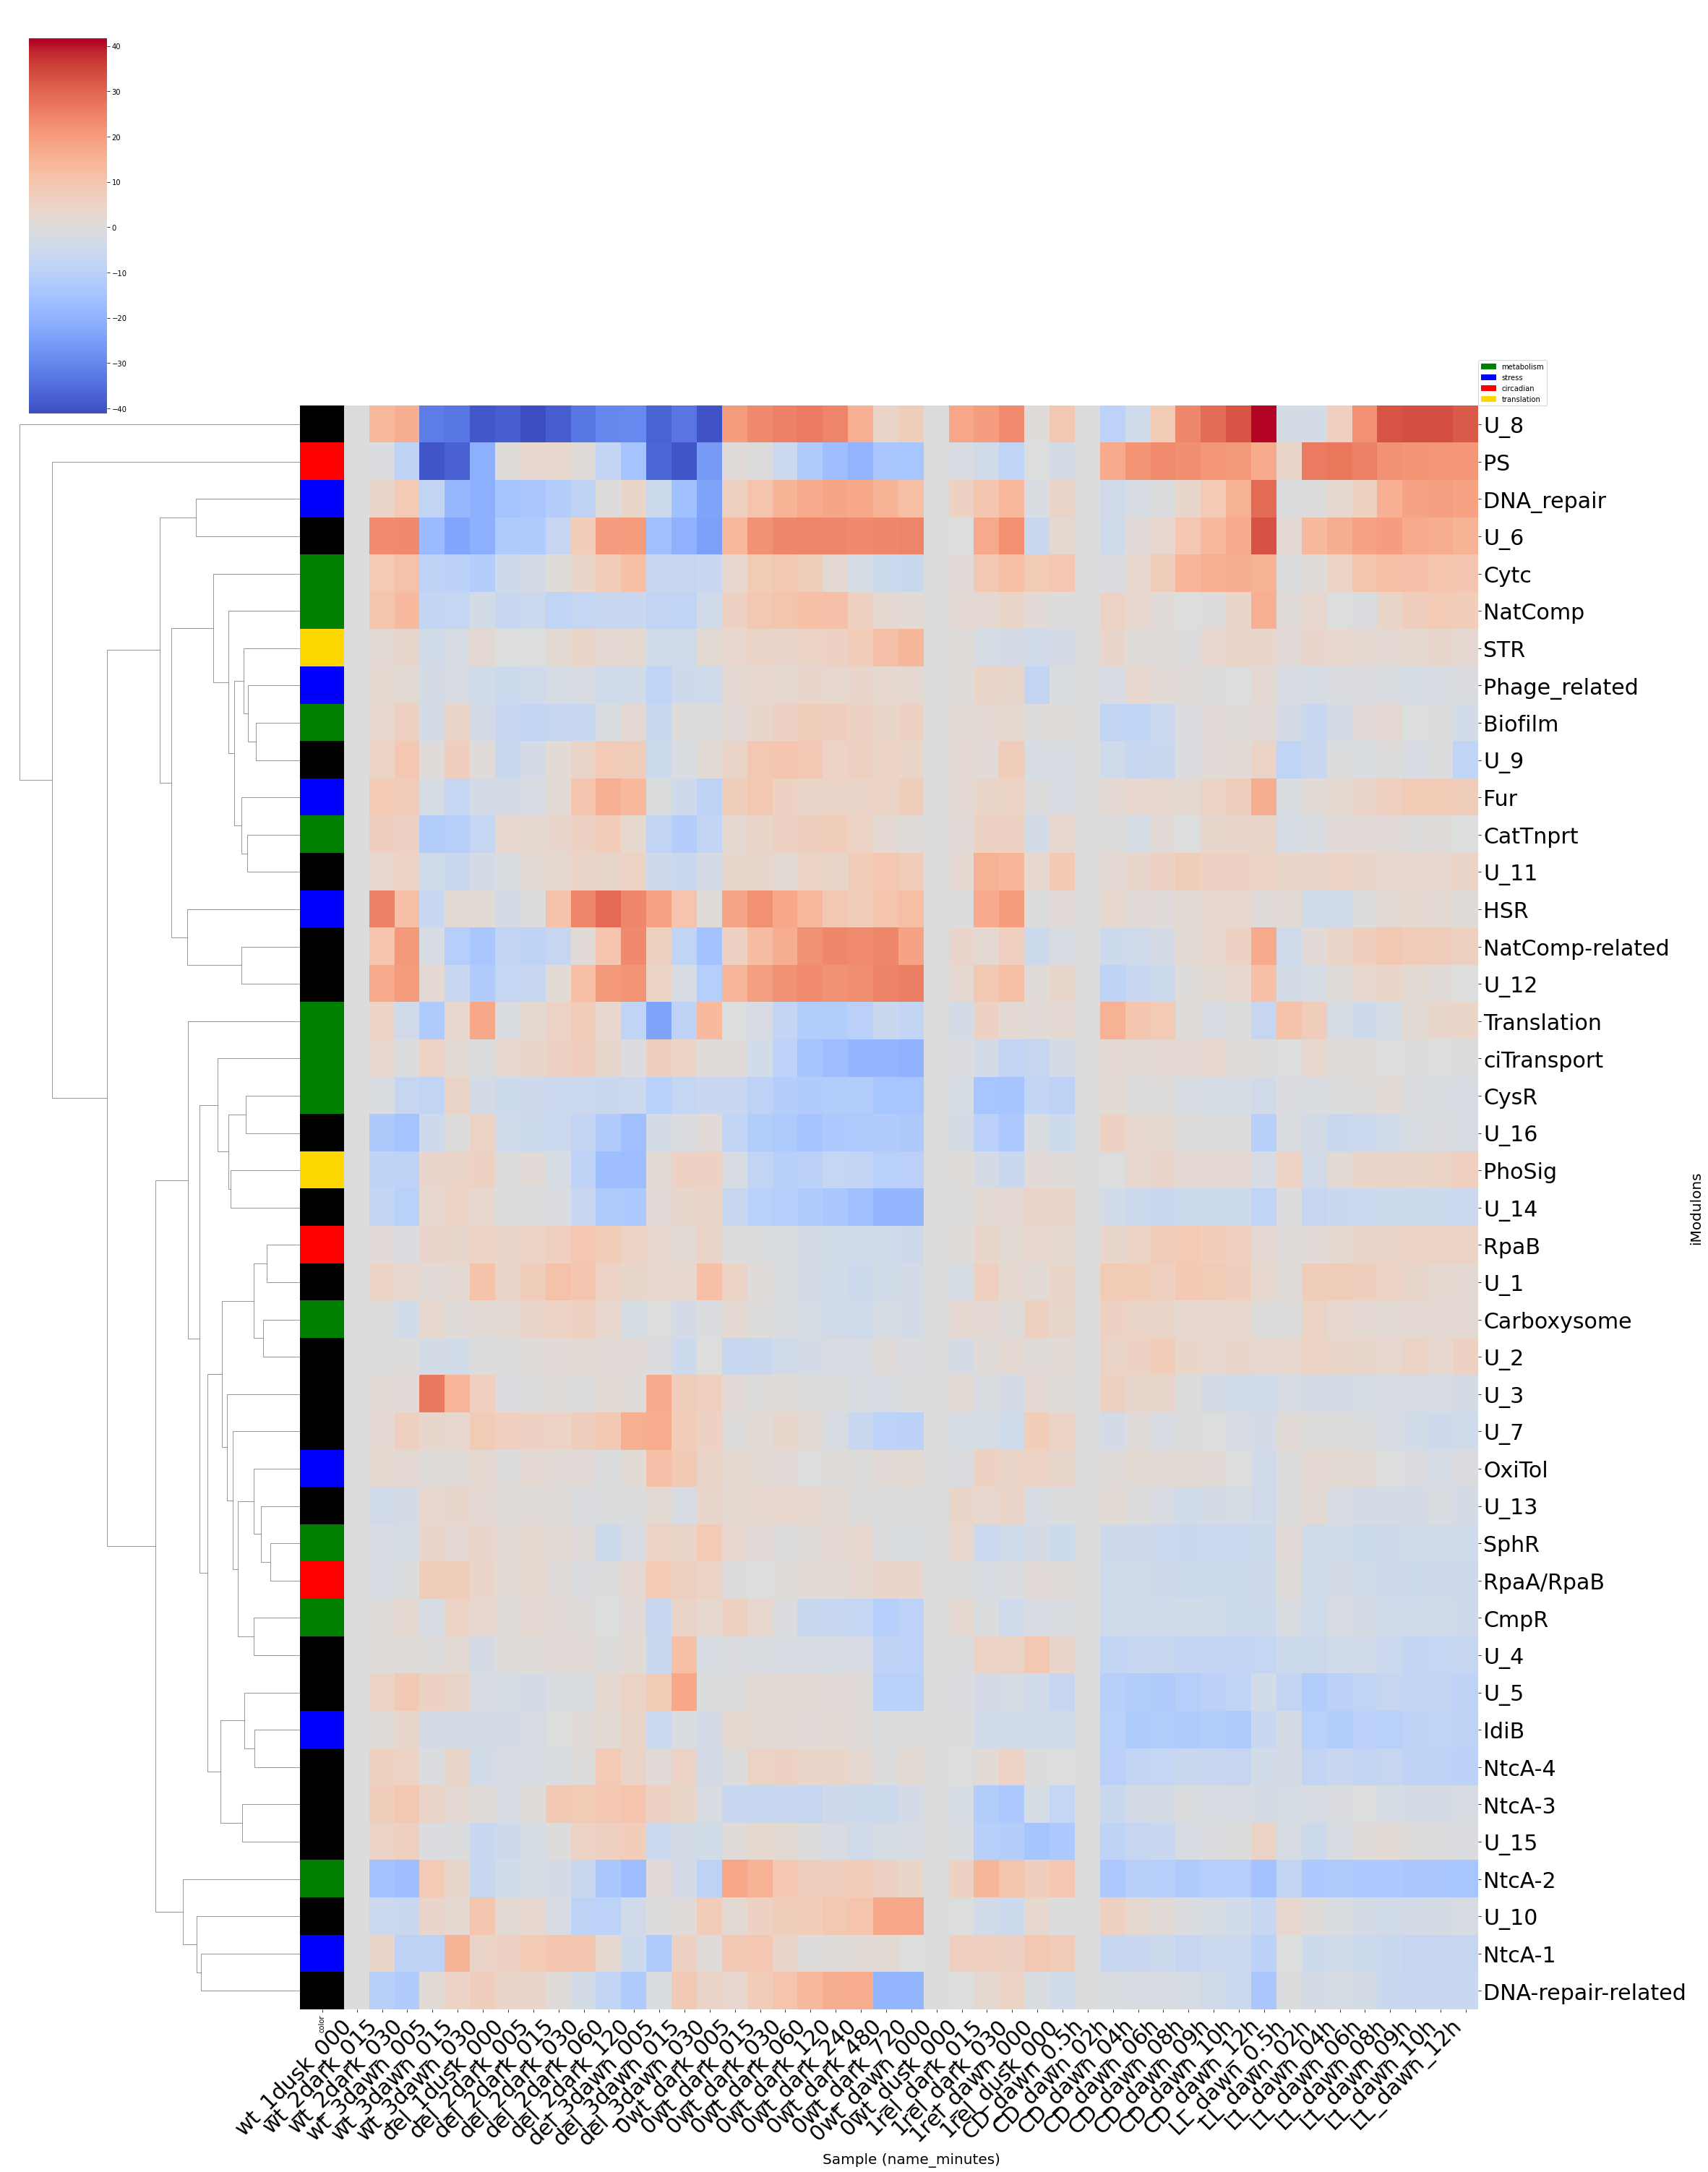

In [27]:
FINAL1 = pd.concat([df_final0,final_df.reindex(df_final0.index)], axis=1)
FINAL2 = pd.concat([FINAL1,final_df2.reindex(FINAL1.index)], axis=1)

row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 20

f = sns.clustermap(FINAL2, figsize = (width_half*1.5, width_half*2),
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 30)
f.ax_heatmap.set_xticklabels(FINAL2.columns,fontsize = 30,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]

f.ax_heatmap.legend(handles = legend, fontsize = 10, loc = (1,1))

## With A_prime Data

In [64]:
plot_iModulons = pd.read_csv(join(data_dir,'plot3.csv'), index_col = 0)
cl = plot_iModulons['color']

In [65]:
#get activities for imodulons 
data = ica_data_prime.A.reindex(index = list(plot_iModulons.index))

,SRX259777,SRX259778,SRX259779,SRX259780,SRX259781,SRX259782,SRX259783,SRX259784,SRX259785,SRX259786,...,SRX4105559,SRX4105560,SRX4105561,SRX4105562,SRX4105563,SRX4105564,SRX4105565,SRX4105566,SRX4105567,SRX4105568
SphR,-1.851249,2.277573,-0.426324,-1.588865,-2.286447,-1.968956,-0.876700,-4.254335,-1.710331,-2.725881,...,0.213838,1.205902,0.040277,1.250335,3.244849,3.880788,2.652467,-0.082185,0.676670,1.626470
IdiB,-1.337483,0.689444,0.648038,2.601095,-1.038134,2.151583,2.939565,3.894132,3.557736,3.333644,...,-5.525201,-5.437025,-3.588135,-3.879868,0.779459,-3.122628,-2.406578,-4.875880,-4.816803,-4.105211
RpaB,1.029500,-0.514617,-0.514883,-0.396655,-0.023619,-1.011621,0.067002,-1.037944,-0.251743,-0.188676,...,-6.856309,-8.353788,-9.357248,2.538957,-5.093868,-4.513474,-6.560258,-8.570017,-8.333606,-8.340283
CmpR,-0.642781,-0.163512,0.806293,0.014077,-0.165414,-0.337552,-1.129806,-1.200798,0.477817,-0.506608,...,6.519048,6.202761,4.909589,-0.891085,8.401156,8.551755,8.818556,6.920621,6.706189,6.794085
PhoSig,1.013862,-0.609245,-0.404617,-2.933093,0.547241,-0.591668,1.054445,-1.740504,0.051012,-0.817803,...,10.121789,11.848933,10.982969,1.775370,7.789223,3.077864,6.331397,9.941546,11.230869,12.109171
Phage_related,-0.088655,-2.005396,2.094051,-2.044300,0.459582,-1.421838,3.318795,0.366606,4.533706,1.894346,...,20.320465,19.455715,16.158655,13.689148,19.680093,17.818962,17.149651,18.940277,15.959297,17.285439
CysR,-0.326824,0.026630,0.300194,0.231335,-0.055464,0.514502,-0.067269,-0.914781,0.078461,-0.351450,...,-0.248854,-0.257550,-0.315557,1.541579,-1.451389,0.233324,0.513514,-0.676532,-0.534902,1.044641
CatTnprt,-1.698471,0.889898,0.808573,-1.142468,-0.465139,1.096653,-0.214885,-1.278907,-1.873431,-0.374779,...,2.389182,2.115131,1.097359,-1.526833,-0.250089,2.638175,3.435226,2.273085,0.872035,1.973491
Translation,1.312121,-1.606873,0.294752,0.140906,1.005307,-0.939849,1.201319,-0.854983,1.051537,2.298763,...,21.293010,23.149542,22.807367,4.340986,13.718708,26.535844,21.573840,20.265878,20.746597,22.684934
Biofilm,-5.543856,10.510422,-4.966566,-4.466449,-9.752223,-6.233003,-7.105709,-6.118058,-10.662499,-5.714899,...,4.245169,3.405248,7.137506,-4.683596,3.542573,2.027719,1.674518,6.425402,4.770976,6.322380


In [ ]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10

f = sns.clustermap(df_finalA, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
# f.set_xticks(range(len(df))) # <--- set the ticks first
f.ax_heatmap.set_xticklabels(list(ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition),fontsize = 10,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'signaling','unknown']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)
None

In [93]:
#take the activities from projects of interest 
samples_in_rpaA = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].index
# df_final0 = data[samples_in_rpaA]

In [39]:
#take the activities from projects of interest 
condition = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition
df_final0 = df_final0.rename(columns=dict(zip(df_final0.columns,condition)))

In [40]:
colors = plot_iModulons.color
colors.index = df_final0.index
correlations = df_final0.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

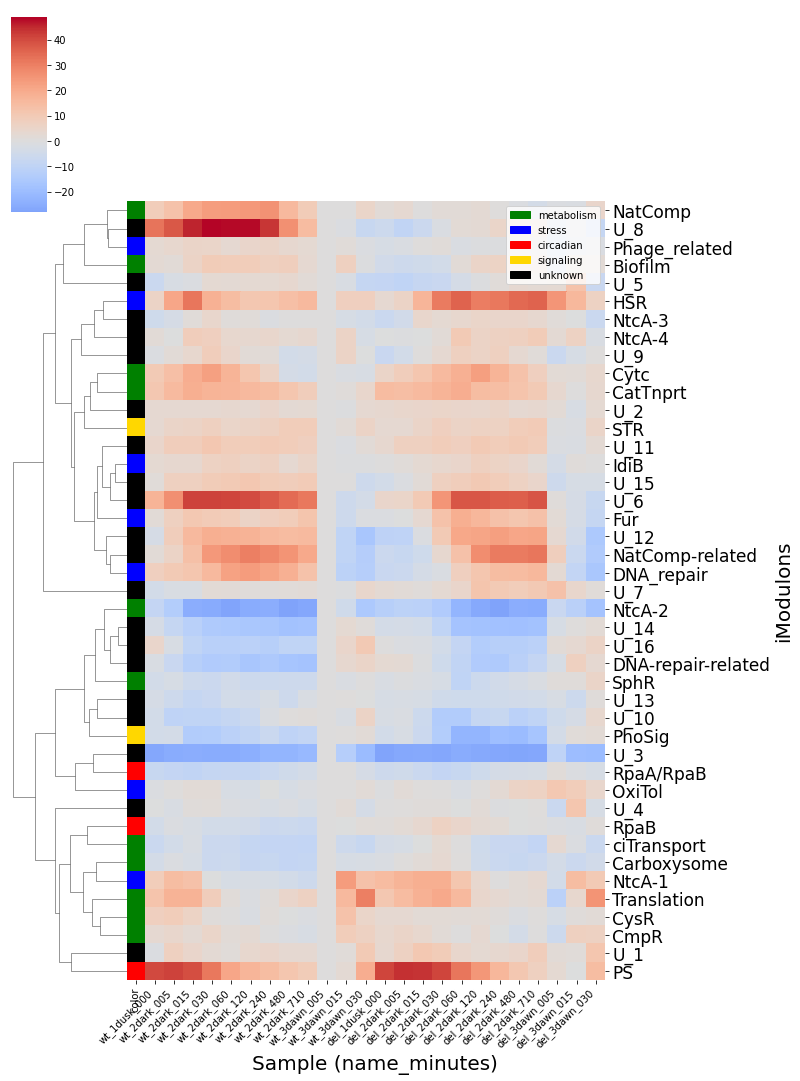

In [41]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10

f = sns.clustermap(df_final0, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
# f.set_xticks(range(len(df))) # <--- set the ticks first
f.ax_heatmap.set_xticklabels(list(ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition),fontsize = 10,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'signaling','unknown']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)
None

In [42]:
#take the activities from projects of interest 
data = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp']
ppGpp_wt = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("0wt_", na = False)
ppGpp_rel = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("1rel_", na = False)
ppGpp_samples = (data[ppGpp_wt].index).append(data[ppGpp_rel].index)
ppGpp_conditions = list((data[ppGpp_wt].condition).append(data[ppGpp_rel].condition))

In [43]:
SRX_condition = dict(zip(ppGpp_samples,ppGpp_conditions))

In [44]:
data = ica_data_prime.A.reindex(index = list(plot_iModulons.index))
df = data[ppGpp_samples]
df = (df.rename(columns=dict(zip(ppGpp_samples,ppGpp_conditions)))).T
final_df = df.groupby(by=df.index).mean()
final_df = final_df.T
final_df

,0wt_dawn_000,0wt_dusk_000,0wt_dusk_005,0wt_dusk_015,0wt_dusk_030,0wt_dusk_060,0wt_dusk_120,0wt_dusk_240,0wt_dusk_480,0wt_dusk_720,1rel_dawn_000,1rel_dusk_000,1rel_dusk_005,1rel_dusk_015,1rel_dusk_030,1rel_dusk_060,1rel_dusk_120,1rel_dusk_240,1rel_dusk_480,1rel_dusk_720
SphR,-1.387779e-16,3.375430,3.421232,1.244201,-0.390497,0.558604,1.731106,2.323625,-1.553760,-2.473577,-2.573335,-4.996129,-7.143198,-5.670270,-4.485233,6.243588,6.499556,8.568009,9.901280,17.145502
IdiB,-9.714451e-16,-0.410178,3.189873,2.711320,2.454788,2.106332,2.127457,1.480024,-0.233592,0.885408,-4.477183,-4.372588,-4.347384,-3.517540,-3.742175,1.879165,2.234807,2.148161,2.476427,7.019197
RpaB,5.551115e-17,0.778076,-0.215663,-0.179801,-0.971137,-2.386394,-3.554698,-4.430992,-4.383416,-4.910980,3.810422,3.254166,4.911460,4.385934,2.785862,-1.760813,-3.544074,-4.548458,-5.526028,-5.241951
CmpR,1.665335e-16,3.078596,5.601780,2.463794,-1.316237,-5.985111,-6.384589,-7.055270,-11.211880,-9.531122,-0.472338,-0.710311,0.943023,-0.400109,-3.971142,-2.859754,-2.775678,-2.208306,-2.819091,2.722998
PhoSig,3.989864e-17,0.884247,-1.830032,-8.571500,-11.455444,-10.133260,-7.757273,-8.683113,-11.379939,-11.233343,1.465498,0.840972,-0.362467,-2.758034,-6.128026,-1.993771,-2.236480,-1.753152,-3.699626,2.881573
Phage_related,5.551115e-17,1.304966,2.396879,3.060863,2.875762,4.181065,3.016855,3.855431,2.931299,2.523257,-7.339262,-1.108748,4.869007,4.485810,3.744472,0.203071,0.983474,2.121307,3.517681,5.977045
CysR,3.053113e-16,-2.026786,-6.137654,-9.170009,-11.481209,-12.361956,-11.937545,-12.010479,-14.481459,-14.608655,-7.909895,-9.226798,-12.889548,-14.552790,-14.995026,-13.156918,-12.040495,-11.884979,-12.679346,-10.490476
CatTnprt,-6.522560e-16,1.222803,2.614444,4.207143,5.789209,6.984395,7.314522,4.988684,2.195330,0.514769,-3.040665,3.516884,6.091591,5.838470,6.193412,7.803741,6.393002,4.980161,2.996067,3.487693
Translation,-4.996004e-16,-3.186236,-0.018445,-1.437421,-7.521953,-11.912573,-11.508692,-10.076238,-5.770385,-7.632173,1.252301,2.262377,6.719584,5.733316,2.532701,-12.602207,-15.589966,-16.909304,-18.839752,-33.237340
Biofilm,1.249001e-16,1.719196,1.460400,3.894831,5.977291,7.717677,7.649171,6.173057,5.172947,6.804906,0.492140,0.715703,1.522848,2.420955,2.828651,4.137050,5.175017,5.467147,3.191537,6.055116


In [45]:
correlations = final_df.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

In [46]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10
# colors = plot_iModulons.color
# colors.index = plot_iModulons.index

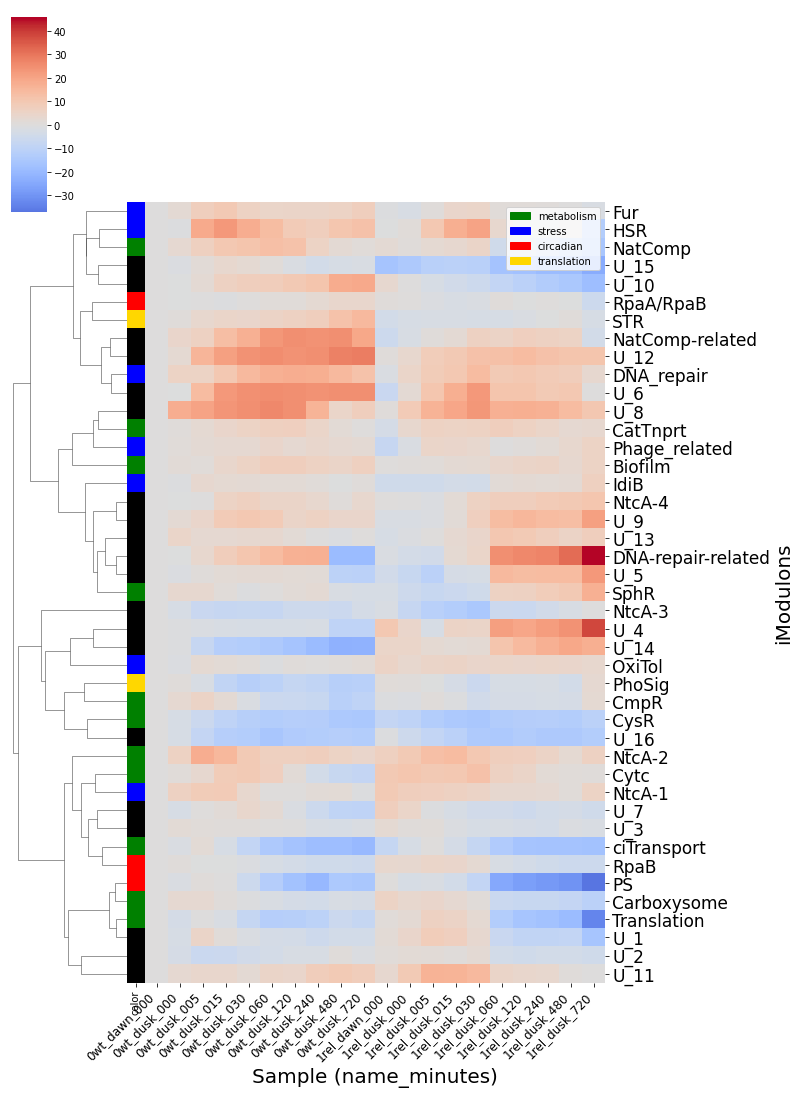

In [47]:
f = sns.clustermap(final_df, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
f.ax_heatmap.set_xticklabels(final_df.columns,fontsize = 12,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)

In [48]:
#take the activities from projects of interest 
data = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light']
samples = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].index
condition_LL = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("LL_", na = False)
condition_CD = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("CD_", na = False)

light_samples = (data[condition_LL].index).append(data[condition_CD].index)
light_conditions = list((data[condition_LL].condition).append(data[condition_CD].condition))

In [49]:
SRX_condition = dict(zip(light_samples,light_conditions))
SRX_condition

{'SRX3211304': 'LL_dawn_0.5h',
 'SRX3211305': 'LL_dawn_0.5h',
 'SRX3211306': 'LL_dawn_02h',
 'SRX3211307': 'LL_dawn_02h',
 'SRX3211308': 'LL_dawn_04h',
 'SRX3211309': 'LL_dawn_04h',
 'SRX3211310': 'LL_dawn_06h',
 'SRX3211311': 'LL_dawn_06h',
 'SRX3211312': 'LL_dawn_08h',
 'SRX3211313': 'LL_dawn_08h',
 'SRX3211314': 'LL_dawn_09h',
 'SRX3211315': 'LL_dawn_09h',
 'SRX3211316': 'LL_dawn_10h',
 'SRX3211317': 'LL_dawn_10h',
 'SRX3211318': 'LL_dawn_12h',
 'SRX3211319': 'LL_dawn_12h',
 'SRX3211320': 'CD_dawn_0.5h',
 'SRX3211321': 'CD_dawn_0.5h',
 'SRX3211322': 'CD_dawn_02h',
 'SRX3211323': 'CD_dawn_02h',
 'SRX3211324': 'CD_dawn_04h',
 'SRX3211325': 'CD_dawn_04h',
 'SRX3211326': 'CD_dawn_06h',
 'SRX3211327': 'CD_dawn_06h',
 'SRX3211328': 'CD_dawn_08h',
 'SRX3211329': 'CD_dawn_08h',
 'SRX3211330': 'CD_dawn_09h',
 'SRX3211331': 'CD_dawn_09h',
 'SRX3211332': 'CD_dawn_10h',
 'SRX3211333': 'CD_dawn_10h',
 'SRX3211334': 'CD_dawn_12h',
 'SRX3211335': 'CD_dawn_12h'}

In [50]:
data = ica_data_prime.A.reindex(index = list(plot_iModulons.index))
df = data[light_samples]
df = (df.rename(columns=SRX_condition)).T
final_df2 = df.groupby(by=df.index).mean()
final_df2 = final_df2.T
final_df2

,CD_dawn_0.5h,CD_dawn_02h,CD_dawn_04h,CD_dawn_06h,CD_dawn_08h,CD_dawn_09h,CD_dawn_10h,CD_dawn_12h,LL_dawn_0.5h,LL_dawn_02h,LL_dawn_04h,LL_dawn_06h,LL_dawn_08h,LL_dawn_09h,LL_dawn_10h,LL_dawn_12h
SphR,5.551115e-16,-4.407135,-4.206842,-5.253747,-5.835775,-5.648639,-5.440502,-5.426138,1.546522,-4.121283,-3.378929,-5.103102,-4.692717,-3.823243,-3.841933,-4.163963
IdiB,-2.220446e-16,-10.436953,-13.165179,-12.620461,-13.021850,-12.165319,-12.909668,-5.829313,-2.324685,-10.758744,-12.079080,-10.292135,-10.506950,-9.275629,-8.484754,-9.356122
RpaB,2.775558e-17,4.181371,5.535366,8.784311,9.545751,8.590698,7.600697,3.315372,0.997317,1.810790,3.558536,5.022960,5.192641,5.975058,5.702756,6.167367
CmpR,1.110223e-16,-4.845234,-4.159507,-4.051822,-3.541744,-4.175646,-5.434366,-6.356463,-0.766066,-4.831375,-1.753830,-2.431327,-4.292142,-4.658709,-4.108573,-4.699071
PhoSig,-4.440892e-16,-0.035487,3.715029,4.729939,3.181198,3.029056,3.152751,-1.567521,6.165730,-3.818798,2.843378,5.182865,5.697604,5.173099,5.839446,7.433523
Phage_related,1.110223e-15,-1.543146,3.638866,1.874272,1.465780,0.529948,-0.003196,2.527572,-1.560280,-2.045342,-0.696507,-0.615925,-1.040649,-1.979316,-1.357572,-0.697131
CysR,-1.110223e-15,1.477234,-0.264186,0.110099,-2.168083,-2.338493,-2.406661,-4.040550,-0.965297,-1.261932,-0.660172,0.343738,1.533333,-1.240036,-1.560221,-1.634039
CatTnprt,0.000000e+00,0.471427,-2.255117,1.375982,-0.405692,3.381976,3.876453,4.066401,-2.368136,-1.149958,1.382380,1.132418,1.240226,0.307706,0.360652,-0.654366
Translation,6.661338e-16,15.556184,9.873768,8.666186,0.913672,-1.469944,-0.401659,-6.727728,11.027852,7.114382,-2.228735,-4.461368,-2.015826,2.215963,3.896102,4.293746
Biofilm,8.326673e-17,-8.582535,-8.885260,-5.962299,-0.930310,1.311539,0.589389,1.550608,-2.858437,-6.526524,-3.275896,1.305387,2.414856,-0.293928,-0.040960,-3.674114


In [51]:
correlations = final_df2.T.corr()
corr_array = np.asarray(correlations)
method = 'weighted'

In [52]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 10
# colors = plot_iModulons.color
# colors.index = plot_iModulons.index

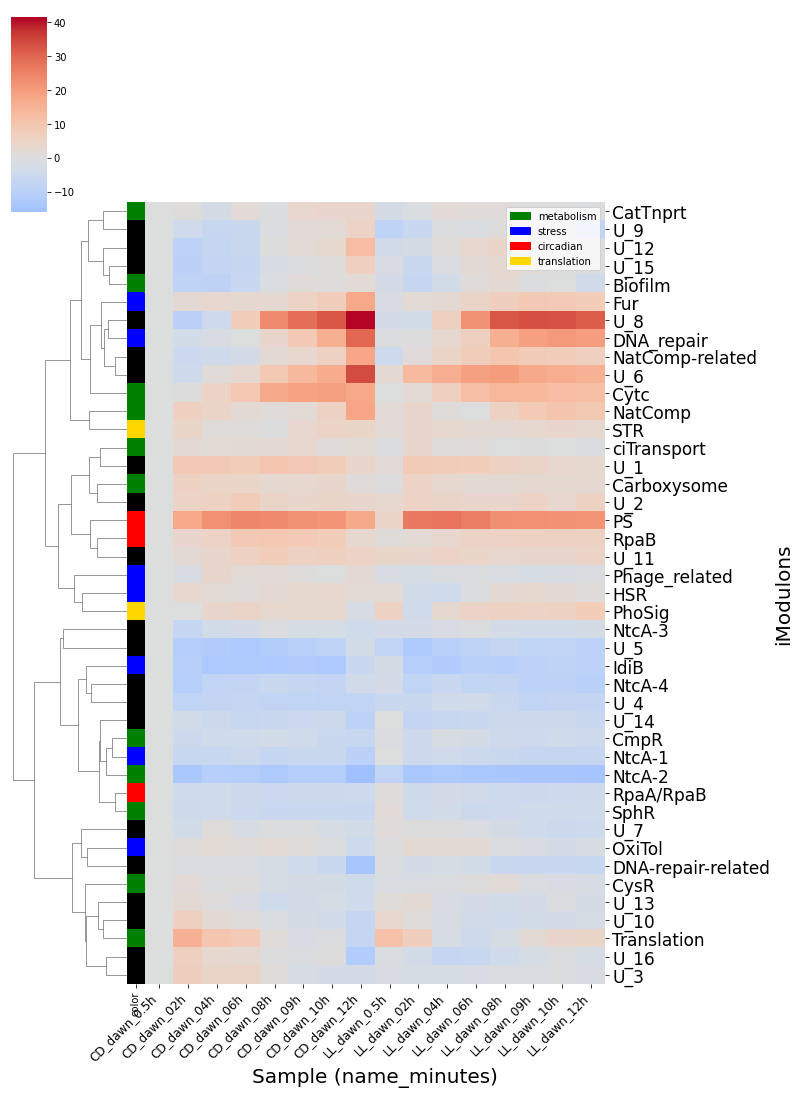

In [53]:
f = sns.clustermap(final_df2, figsize = (width_half, 1.5*width_half), row_linkage = row_linkage,
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
f.ax_heatmap.set_xticklabels(final_df2.columns,fontsize = 12,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]
f.ax_heatmap.legend(handles = legend, fontsize = 10)

### Final figure

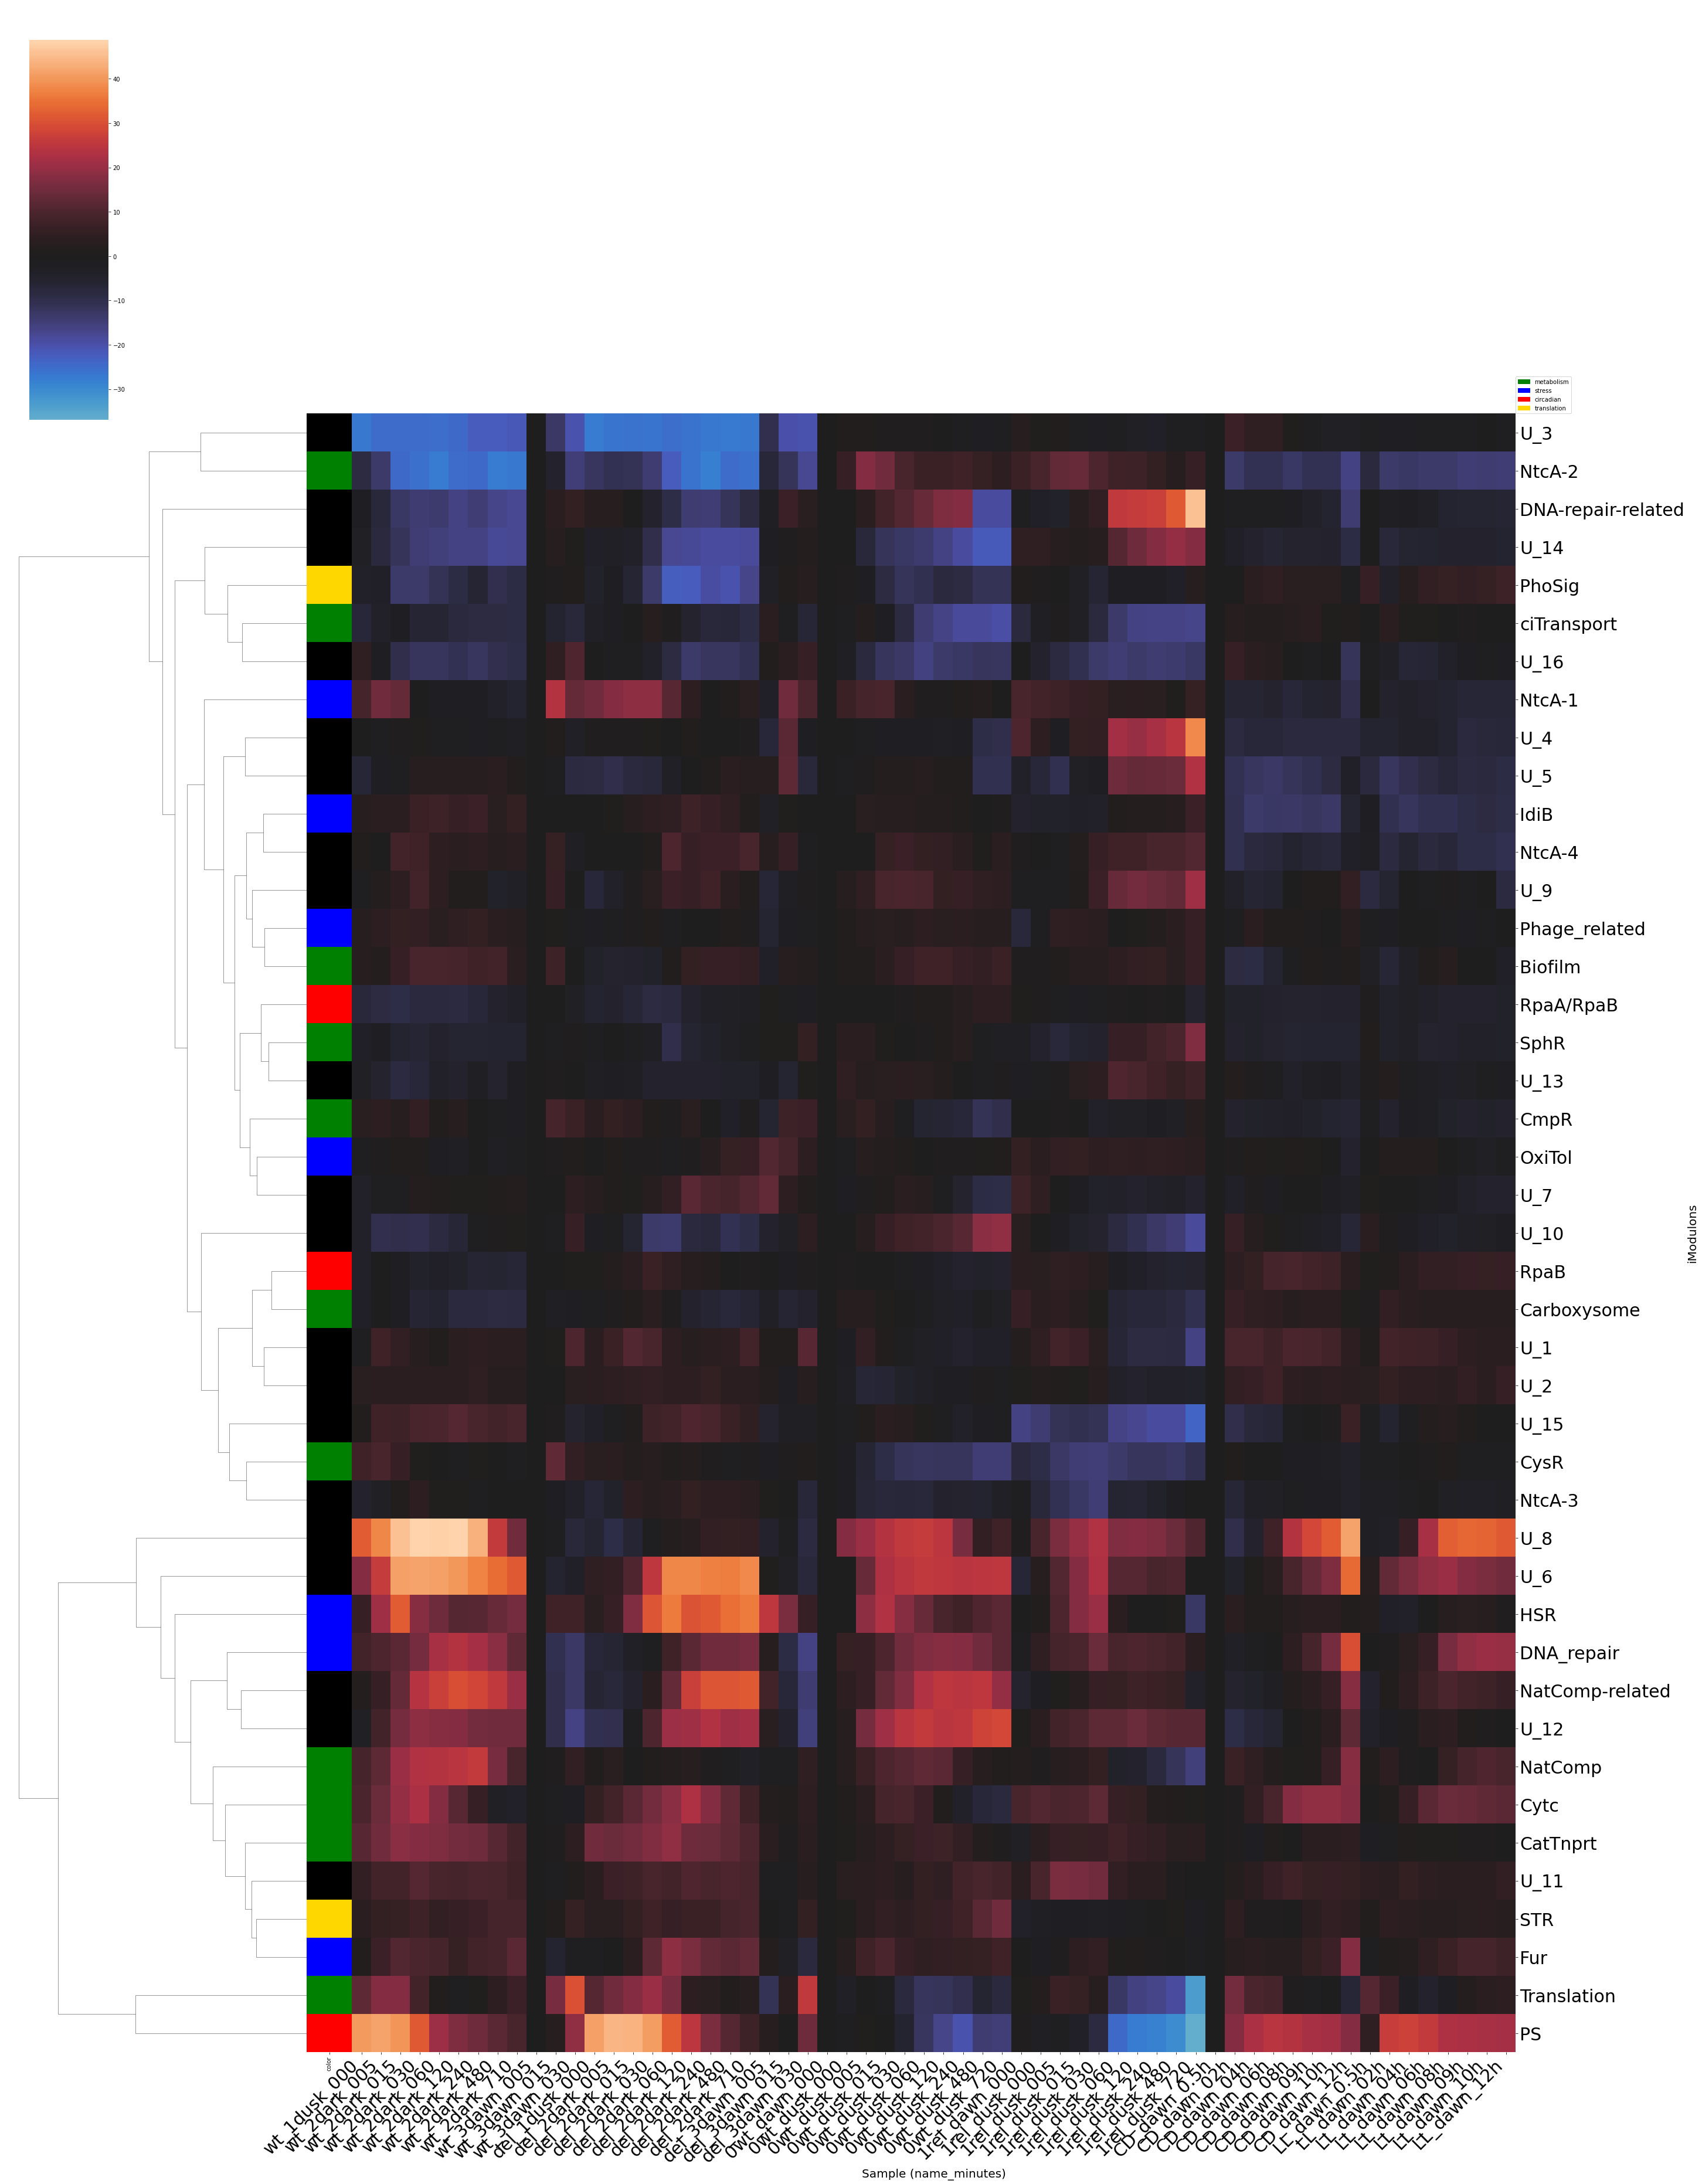

In [63]:
FINAL1 = pd.concat([df_final0,final_df.reindex(df_final0.index)], axis=1)
FINAL2 = pd.concat([FINAL1,final_df2.reindex(FINAL1.index)], axis=1)

row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 25

f = sns.clustermap(FINAL2, figsize = (width_half*1.5, width_half*2),
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'icefire', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 20)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 20)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize = 30)
f.ax_heatmap.set_xticklabels(FINAL2.columns,fontsize = 30,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]

f.ax_heatmap.legend(handles = legend, fontsize = 10, loc = (1,1))

## NtcA-specific 

In [172]:
#loading_data:
plot_iModulons = pd.read_csv(join(data_dir,'plot3.csv'), index_col = 0)
cl = plot_iModulons['color']
data = ica_data_prime.A.reindex(index = list(plot_iModulons.index))

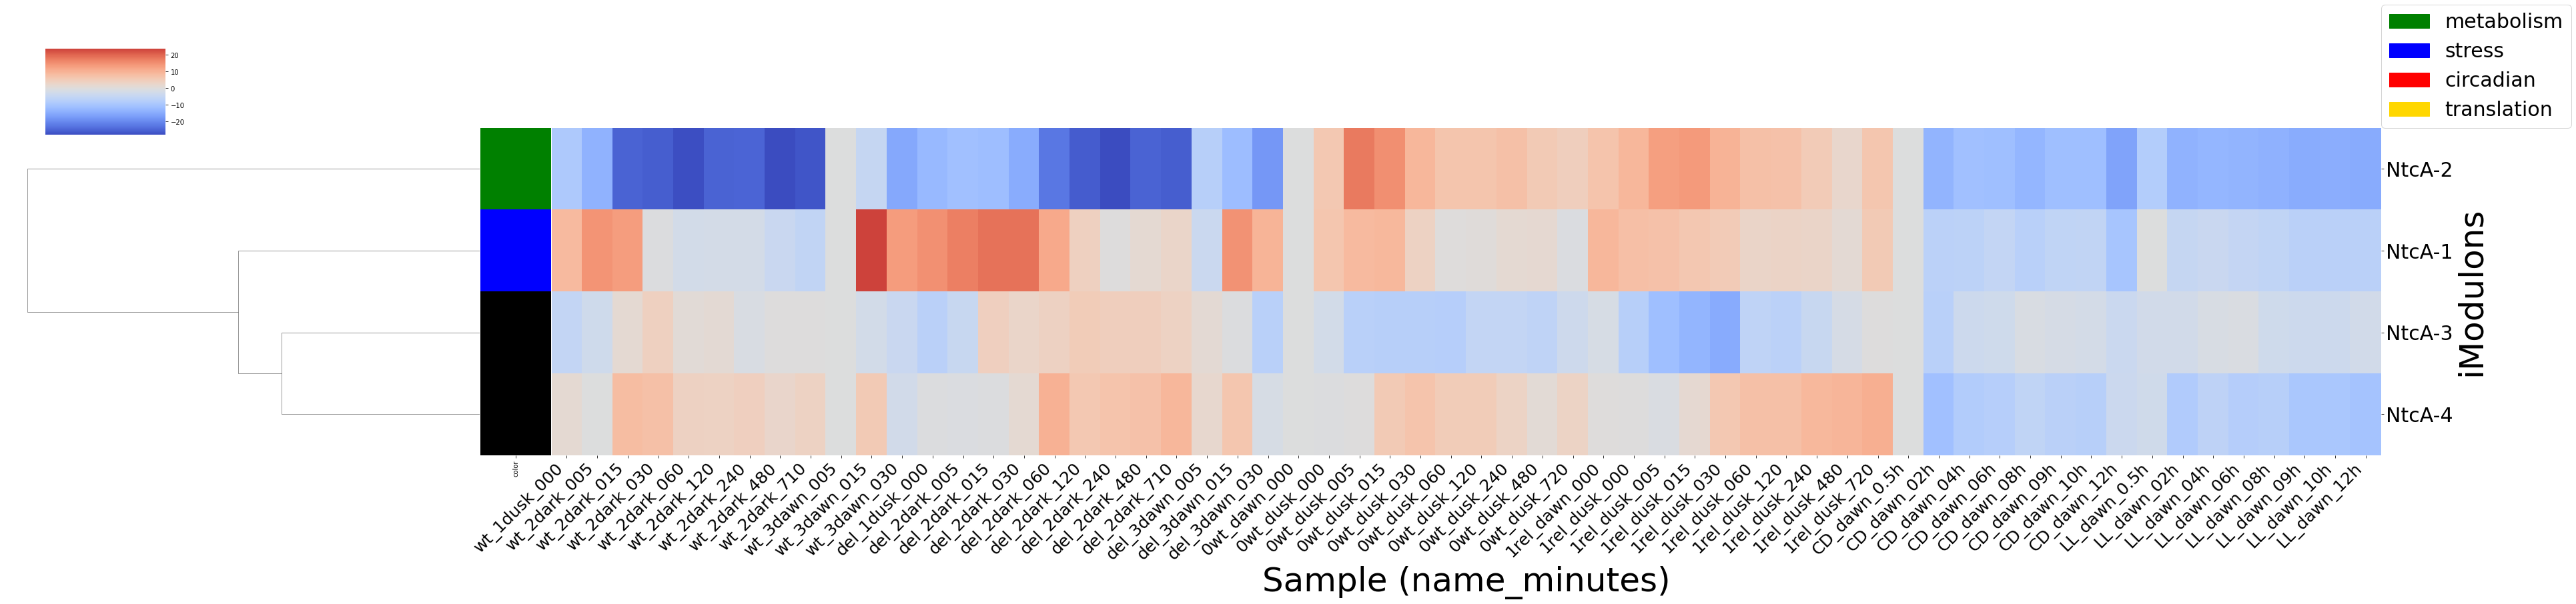

In [175]:
# Unch_list = [i for i in data.index if i.startswith("U_")]
NtcA_list = [i for i in data.index if i.startswith("NtcA-")]
NtcA_data = data.loc[data.index.isin(NtcA_list)]


# rpaA
samples_in_rpaA = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].index
NtcA_rpaA = NtcA_data[samples_in_rpaA]
condition = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition
NtcA_rpaA = NtcA_rpaA.rename(columns=dict(zip(NtcA_rpaA.columns,condition)))

#light
data_light = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light']
samples = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].index
condition_LL = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("LL_", na = False)
condition_CD = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("CD_", na = False)
light_samples = (data_light[condition_LL].index).append(data_light[condition_CD].index)
light_conditions = list((data_light[condition_LL].condition).append(data_light[condition_CD].condition))
SRX_condition = dict(zip(light_samples,light_conditions))
df = data[light_samples]
df = (df.rename(columns=SRX_condition)).T
NtcA_light = df.groupby(by=df.index).mean()
NtcA_light = NtcA_light.T

#ppGpp
data_ppGpp = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp']
ppGpp_wt = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("0wt_", na = False)
ppGpp_rel = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("1rel_", na = False)
ppGpp_samples = (data_ppGpp[ppGpp_wt].index).append(data_ppGpp[ppGpp_rel].index)
ppGpp_conditions = list((data_ppGpp[ppGpp_wt].condition).append(data_ppGpp[ppGpp_rel].condition))

SRX_condition = dict(zip(ppGpp_samples,ppGpp_conditions))
df = data[ppGpp_samples]
df = (df.rename(columns=dict(zip(ppGpp_samples,ppGpp_conditions)))).T
NtcA_pp = df.groupby(by=df.index).mean()
NtcA_pp = NtcA_pp.T

#Final
FINAL1 = pd.concat([NtcA_rpaA,NtcA_pp.reindex(NtcA_rpaA.index)], axis=1)
FINAL2 = pd.concat([FINAL1,NtcA_light.reindex(FINAL1.index)], axis=1)
FINAL2
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 25

f = sns.clustermap(FINAL2, figsize = (width_half*2, width_half/2.5),
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'coolwarm', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 50)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 50)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), rotation= 0,fontsize = 30)
f.ax_heatmap.set_xticklabels(FINAL2.columns,fontsize = 25,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]

f.ax_heatmap.legend(handles = legend, fontsize = 30, loc = (1,1))

In [177]:
f.savefig(data_dir+"NtcA.pdf", transparent=True)

## Uncharacterized

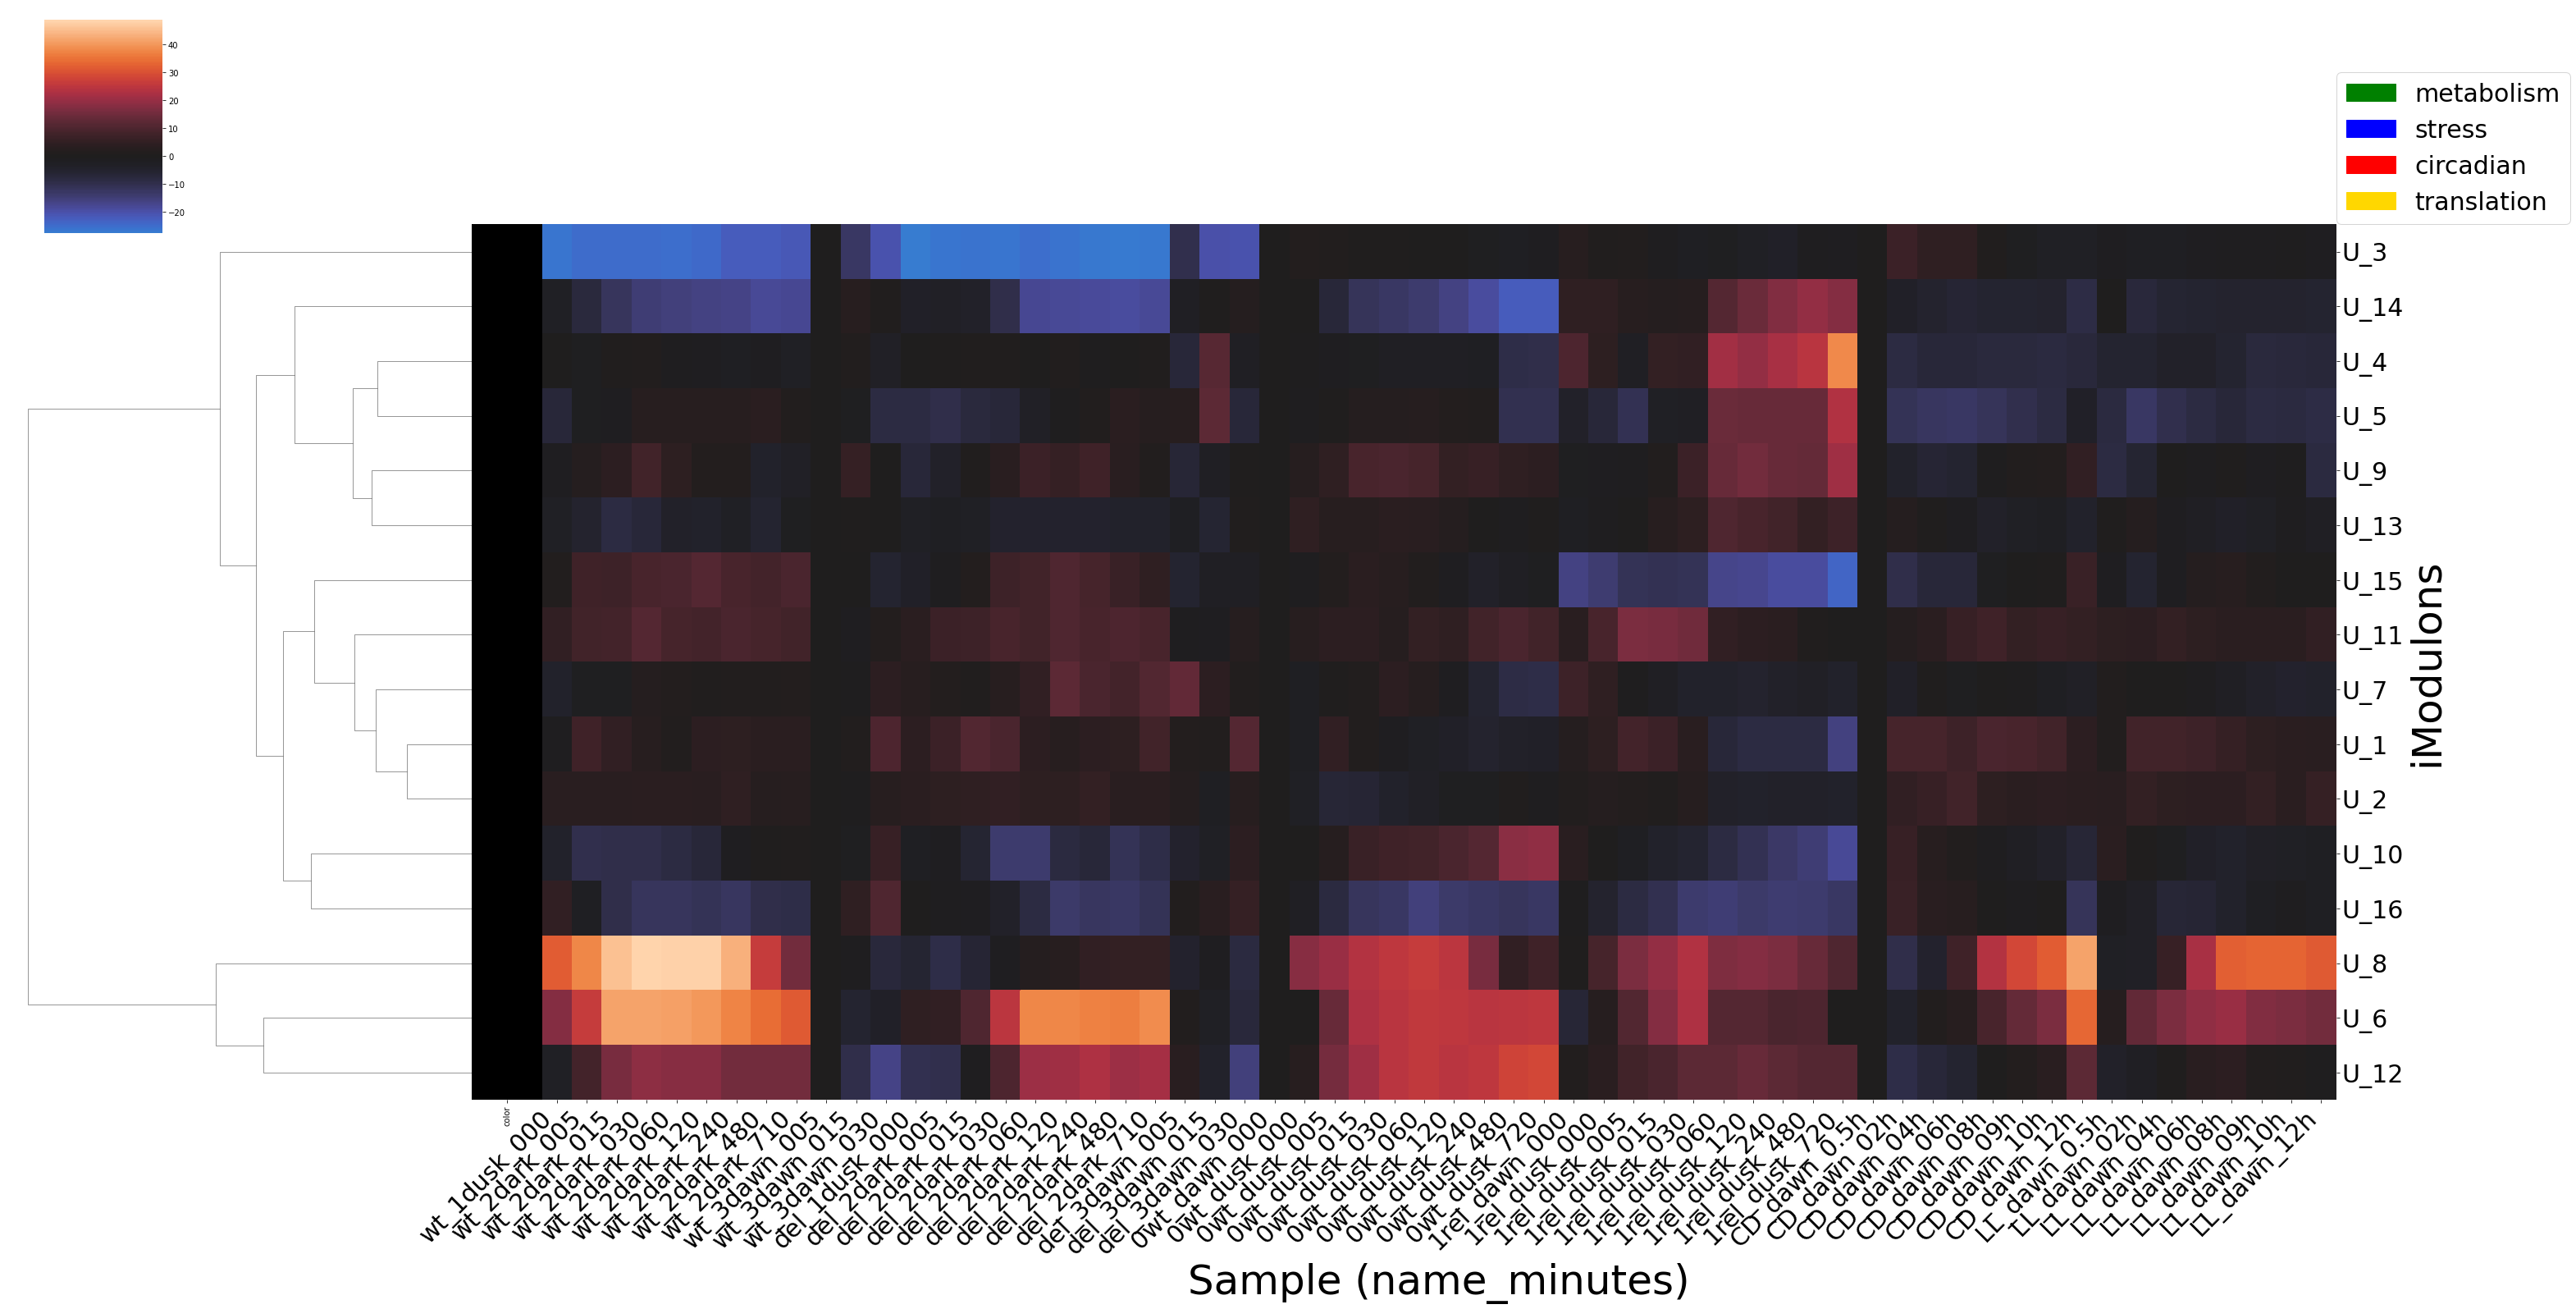

In [167]:
# Unch_list = [i for i in data.index if i.startswith("U_")]
U_list = [i for i in data.index if i.startswith("U_")]
U_data = data.loc[data.index.isin(U_list)]


# rpaA
samples_in_rpaA = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].index
U_rpaA = U_data[samples_in_rpaA]
condition = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition
U_rpaA = U_rpaA.rename(columns=dict(zip(U_rpaA.columns,condition)))

#light
data_light = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light']
samples = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].index
condition_LL = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("LL_", na = False)
condition_CD = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("CD_", na = False)
light_samples = (data_light[condition_LL].index).append(data_light[condition_CD].index)
light_conditions = list((data_light[condition_LL].condition).append(data_light[condition_CD].condition))
SRX_condition = dict(zip(light_samples,light_conditions))
df = data[light_samples]
df = (df.rename(columns=SRX_condition)).T
U_light = df.groupby(by=df.index).mean()
U_light = U_light.T

#ppGpp
data_ppGpp = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp']
ppGpp_wt = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("0wt_", na = False)
ppGpp_rel = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("1rel_", na = False)
ppGpp_samples = (data_ppGpp[ppGpp_wt].index).append(data_ppGpp[ppGpp_rel].index)
ppGpp_conditions = list((data_ppGpp[ppGpp_wt].condition).append(data_ppGpp[ppGpp_rel].condition))

SRX_condition = dict(zip(ppGpp_samples,ppGpp_conditions))
df = data[ppGpp_samples]
df = (df.rename(columns=dict(zip(ppGpp_samples,ppGpp_conditions)))).T
U_pp = df.groupby(by=df.index).mean()
U_pp = U_pp.T

#Final
FINAL1 = pd.concat([U_rpaA,U_pp.reindex(U_rpaA.index)], axis=1)
FINAL2 = pd.concat([FINAL1,U_light.reindex(FINAL1.index)], axis=1)
FINAL2
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 20

f = sns.clustermap(FINAL2, figsize = (width_half*2, width_half),
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'icefire', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 50)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 50)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), rotation= 0,fontsize = 30)
f.ax_heatmap.set_xticklabels(FINAL2.columns,fontsize = 30,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]

f.ax_heatmap.legend(handles = legend, fontsize = 30, loc = (1,1))

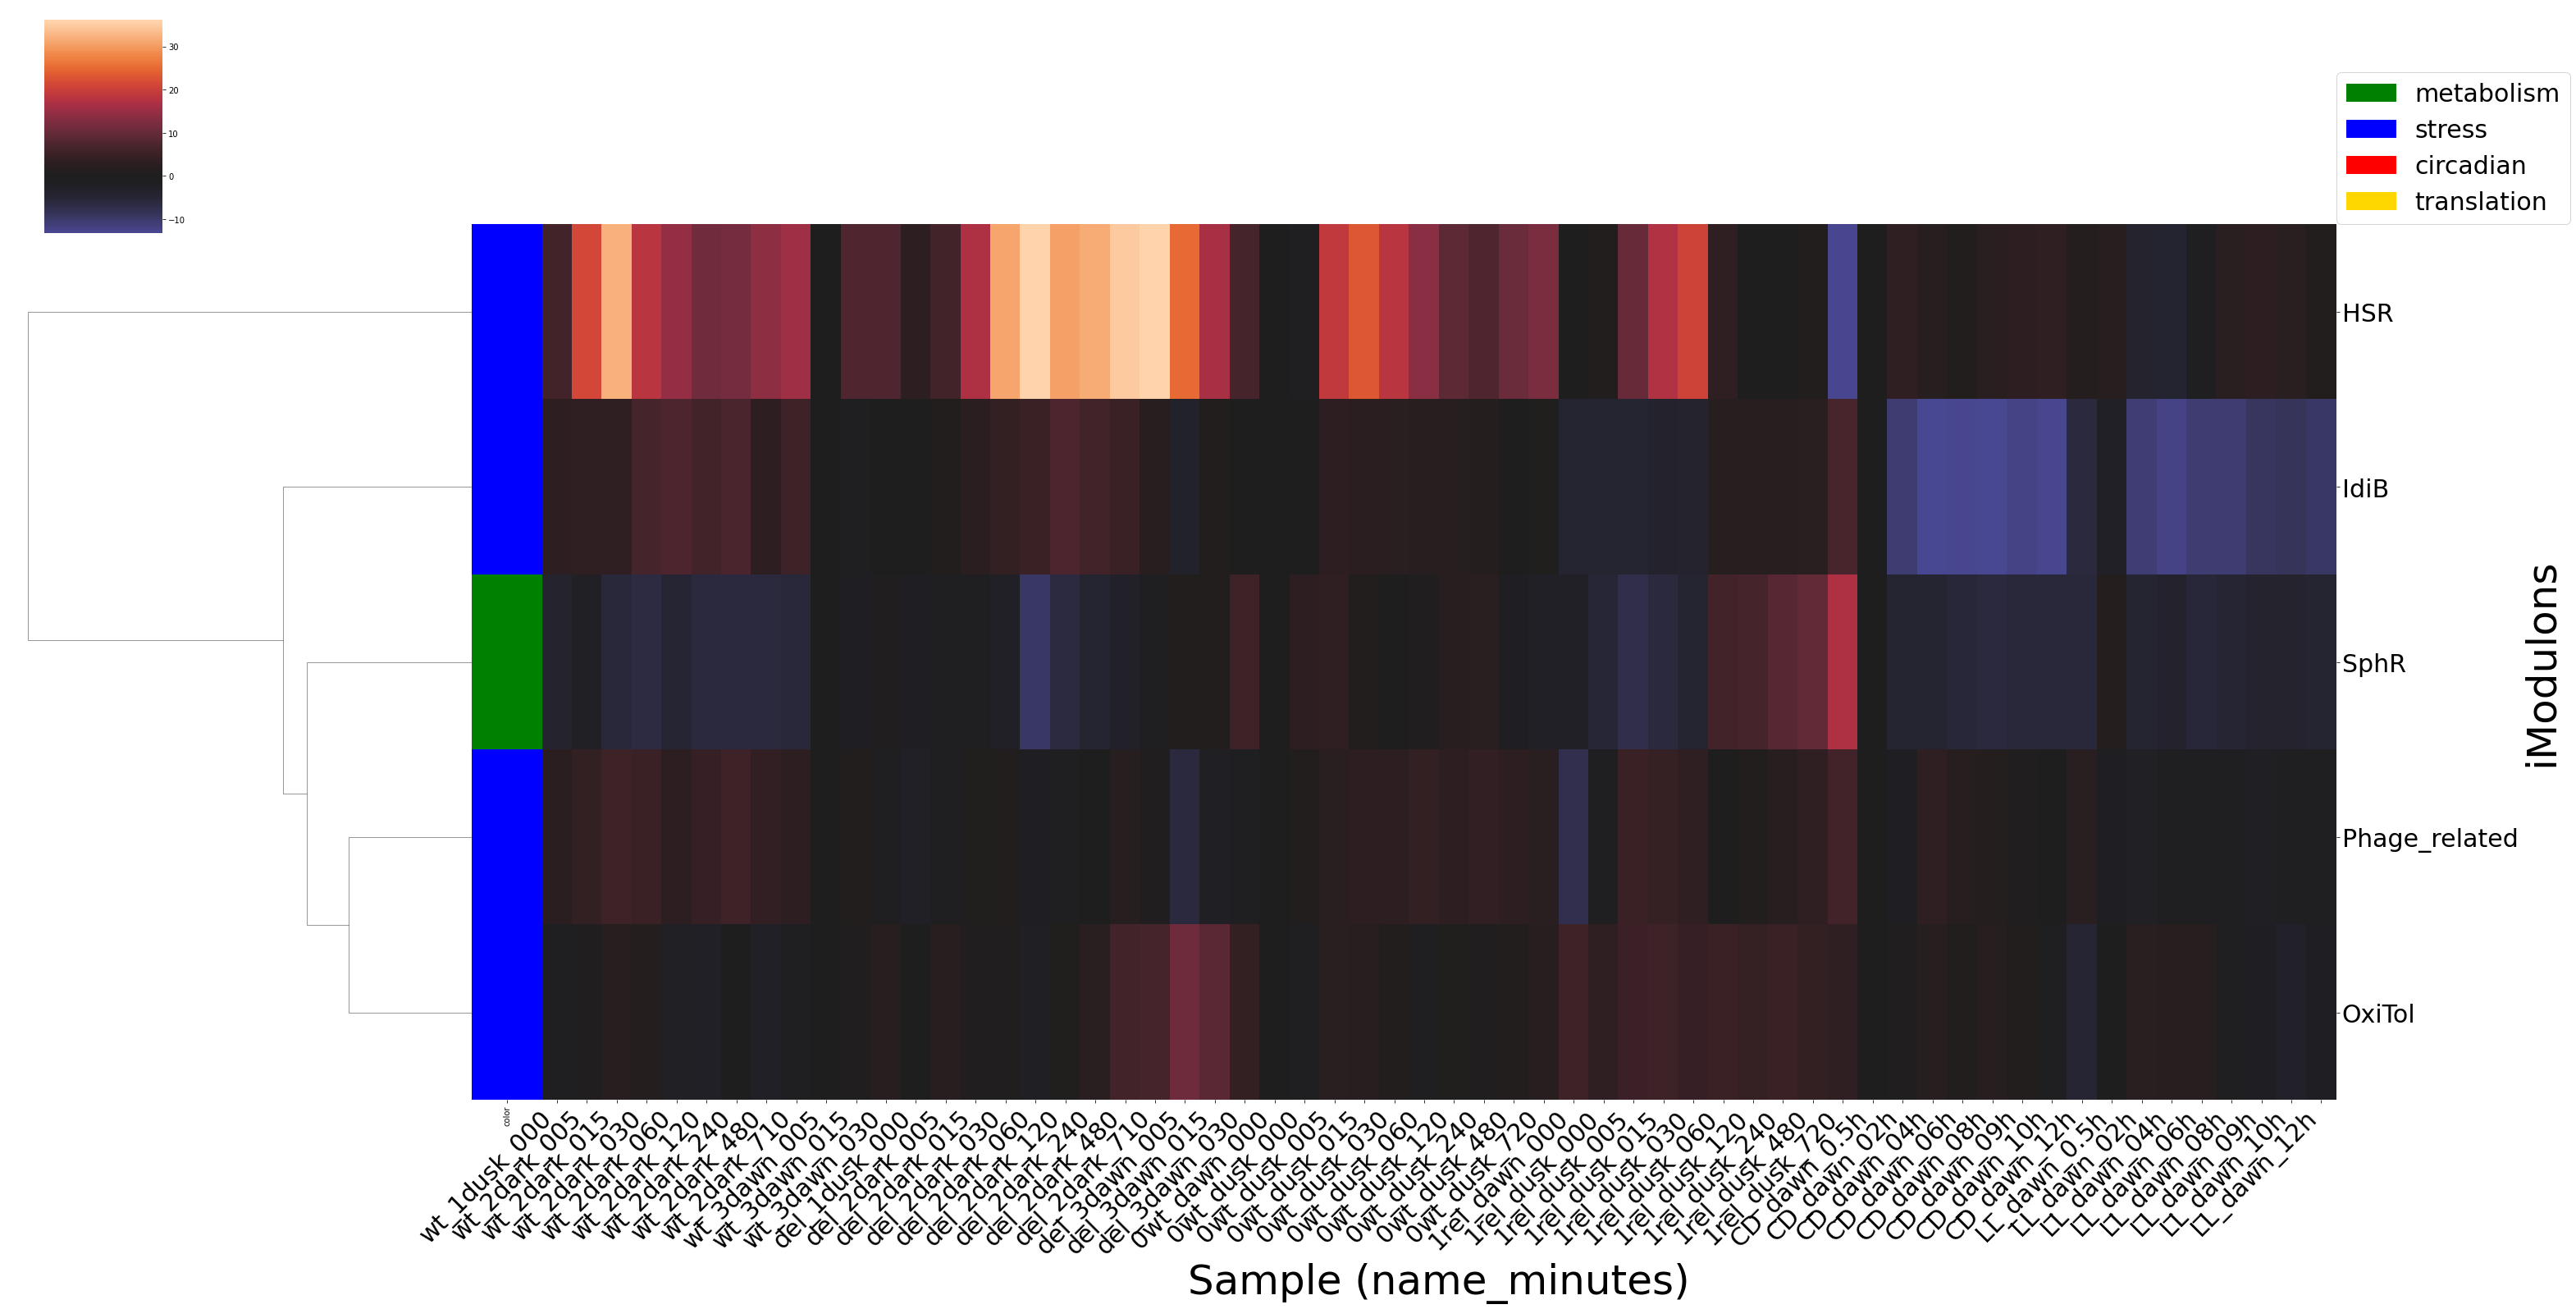

In [170]:
# Unch_list = [i for i in data.index if i.startswith("U_")]
strs_data = data.loc[data.index.isin(['SphR', 'IdiB','Phage_related','OxiTol','HSR'])]


# rpaA
samples_in_rpaA = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].index
strs_rpaA = strs_data[samples_in_rpaA]
condition = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'rpaA'].condition
strs_rpaA = strs_rpaA.rename(columns=dict(zip(strs_rpaA.columns,condition)))

#light
data_light = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light']
samples = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].index
condition_LL = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("LL_", na = False)
condition_CD = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'light'].condition.str.startswith("CD_", na = False)
light_samples = (data_light[condition_LL].index).append(data_light[condition_CD].index)
light_conditions = list((data_light[condition_LL].condition).append(data_light[condition_CD].condition))
SRX_condition = dict(zip(light_samples,light_conditions))
df = data[light_samples]
df = (df.rename(columns=SRX_condition)).T
strs_light = df.groupby(by=df.index).mean()
strs_light = strs_light.T

#ppGpp
data_ppGpp = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp']
ppGpp_wt = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("0wt_", na = False)
ppGpp_rel = ica_data_prime.sample_table[ica_data_prime.sample_table.project == 'ppGpp'].condition.str.startswith("1rel_", na = False)
ppGpp_samples = (data_ppGpp[ppGpp_wt].index).append(data_ppGpp[ppGpp_rel].index)
ppGpp_conditions = list((data_ppGpp[ppGpp_wt].condition).append(data_ppGpp[ppGpp_rel].condition))

SRX_condition = dict(zip(ppGpp_samples,ppGpp_conditions))
df = data[ppGpp_samples]
df = (df.rename(columns=dict(zip(ppGpp_samples,ppGpp_conditions)))).T
strs_pp = df.groupby(by=df.index).mean()
strs_pp = strs_pp.T

#Final
FINAL1 = pd.concat([strs_rpaA,strs_pp.reindex(strs_rpaA.index)], axis=1)
FINAL2 = pd.concat([FINAL1,strs_light.reindex(FINAL1.index)], axis=1)
FINAL2
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = method,optimal_ordering = True)
width_half = 20

f = sns.clustermap(FINAL2, figsize = (width_half*2, width_half),
                   method = method,row_colors = colors,
                   col_cluster = False, cmap = 'icefire', center = 0)

f.ax_heatmap.set_xlabel('Sample (name_minutes)', fontsize = 50)
f.ax_heatmap.set_ylabel('iModulons', fontsize = 50)
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), rotation= 0,fontsize = 30)
f.ax_heatmap.set_xticklabels(FINAL2.columns,fontsize = 30,rotation= 45, ha ="right")

# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
None
labels = ['metabolism', 'stress', 'circadian', 'translation']
legend = [mpatches.Patch(color = c, label = l) for c, l in zip(cl.unique(), labels)]

f.ax_heatmap.legend(handles = legend, fontsize = 30, loc = (1,1))

# Venn diagram

In [12]:
import matplotlib
matplotlib.use('Agg')

import venn

ModuleNotFoundError: No module named 'venn'